In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Flickr, Coauthor, CoraFull, Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.loader import NeighborLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import networkx as nx

/home/bolt17/miniconda3/envs/StableVITON/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def visualize_graph(G, color):
    plt.figure(figsize=(103,103))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [3]:
np.random.seed(69420)
torch.manual_seed(69420)

In [4]:
# Load the Flickr dataset
dataset = Planetoid(root='data/Planetoid', name='Cora')
data = dataset[0]  # The dataset contains a single graph

In [5]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [6]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [6]:
def edge_index_to_adj(edge_index, num_nodes):
    values = torch.ones(edge_index.shape[1])
    adj_matrix = torch.sparse_coo_tensor(edge_index, values, (num_nodes, num_nodes))
    return adj_matrix.to_dense()
adj_matrix = edge_index_to_adj(data.edge_index, len(data.x))

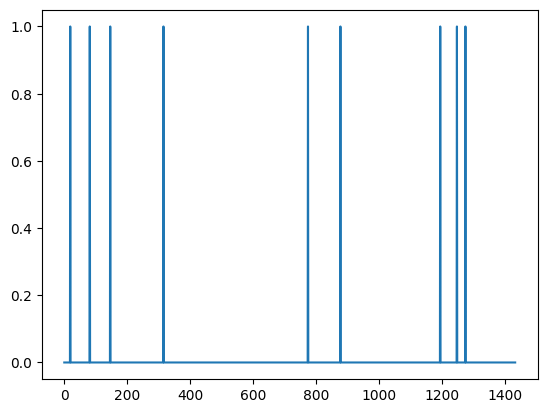

In [7]:
plt.plot(data.x[0])

In [8]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

B:adj_matrix,A:similarities,M:features

In [10]:
features = torch.tensor(data.x)
# finding feature similarity across all the nodes via dot product
similarities = (features@features.T)

/tmp/ipykernel_231832/1608751072.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


In [11]:
#M = (B==0).long() * A * (torch.eye(len(A)) == 0).long()
# making the diagnol elements to zero as the max similarity is obtained with a same
similarities = similarities * (torch.eye(len(similarities)) == 0).long()
similarities

tensor([[0., 1., 1.,  ..., 1., 2., 2.],
        [1., 0., 3.,  ..., 2., 1., 1.],
        [1., 3., 0.,  ..., 2., 1., 1.],
        ...,
        [1., 2., 2.,  ..., 0., 0., 1.],
        [2., 1., 1.,  ..., 0., 0., 2.],
        [2., 1., 1.,  ..., 1., 2., 0.]])

In [12]:
maxi = similarities.max()

maxi

tensor(25.)

In [13]:
similarities=torch.div(similarities, maxi)
similarities

tensor([[0.0000, 0.0400, 0.0400,  ..., 0.0400, 0.0800, 0.0800],
        [0.0400, 0.0000, 0.1200,  ..., 0.0800, 0.0400, 0.0400],
        [0.0400, 0.1200, 0.0000,  ..., 0.0800, 0.0400, 0.0400],
        ...,
        [0.0400, 0.0800, 0.0800,  ..., 0.0000, 0.0000, 0.0400],
        [0.0800, 0.0400, 0.0400,  ..., 0.0000, 0.0000, 0.0800],
        [0.0800, 0.0400, 0.0400,  ..., 0.0400, 0.0800, 0.0000]])

In [14]:
alpha = 0.25
max_similarities = (similarities > alpha).long()

In [15]:
new_edges = torch.nonzero(max_similarities, as_tuple=False).T

In [16]:
existing_edges = set(map(tuple, data.edge_index.T.tolist()))

In [17]:
# check if there is a common edges between the ones we found and existing ones
filtered_new_edges = []
for i, j in new_edges.T.tolist():
    if (i, j) not in existing_edges and (j, i) not in existing_edges:  # Avoid duplicates
        filtered_new_edges.append([i, j])

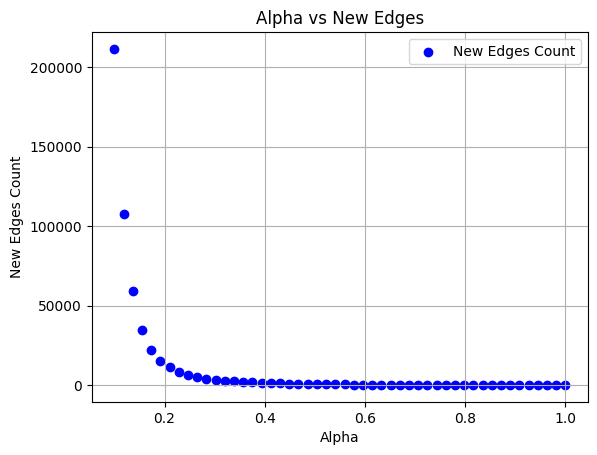

In [55]:
alpha_values = np.linspace(0.1, 1, 50)  # 50 values between 0 and 1
new_edges_counts = []

for alpha in alpha_values:
    max_similarities = (similarities > alpha).long()
    new_edges = torch.nonzero(max_similarities, as_tuple=False).T
    existing_edges = set(map(tuple, data.edge_index.T.tolist()))

    # Filter new edges
    filtered_new_edges = []
    for i, j in new_edges.T.tolist():
        if (i, j) not in existing_edges and (j, i) not in existing_edges:
            filtered_new_edges.append([i, j])

    new_edges_counts.append(len(filtered_new_edges))  # Store count of new edges

# Plot alpha vs new_edges
plt.scatter(alpha_values, new_edges_counts, color='blue', label="New Edges Count")
plt.xlabel("Alpha")
plt.ylabel("New Edges Count")
plt.title("Alpha vs New Edges")
plt.grid(True)
plt.legend()
plt.show()

In [18]:
prev_edges = data.edge_index
if filtered_new_edges:
    filtered_new_edges = torch.tensor(filtered_new_edges, dtype=torch.long).T  # Shape: [2, num_new_edges]

    # Append new edges to data.edge_index

    data.edge_index = torch.cat([data.edge_index, filtered_new_edges], dim=1)

print(f"Total new edges added: {filtered_new_edges.shape[1] if len(filtered_new_edges) > 0 else 0}")

Total new edges added: 4122


In [19]:
new_edges = data.edge_index

In [20]:
print(f"previous edges:{len(prev_edges[0])}")
print(f"final edges:{len(new_edges[0])}")

previous edges:10556
final edges:14678


In [21]:
save_edges = lambda args: pd.DataFrame(args[0].T).to_csv(args[1],index=None, header=None, sep=' ', mode='a')
def get_embeddings(
    edges, 
    edges_name="edgelist.txt", 
    k=128,  # Embedding dimension
    a=0.01,  # damping parameter
    partition=1,
    output=False
):
    '''
    "partition": the partition algorithm to use, default is 1.
    0: random bisection
    1: Louvain partition
    2: Louvain first-level partition
    3: Label Propagation partition
    '''
    save_edges((edges, edges_name))
    
    if not os.path.exists('./hierarchy.txt'):
        os.mknod('./hierarchy.txt')
    if not os.path.exists('./vectors.txt'):
        os.mknod('./vectors.txt')
    
    # do hierarchical clustering using Louvain algorithm
    endstr = '> /dev/null 2>&1'
    if(output):
        endstr = ''
    os.system(f'./LouvainNE/recpart ./{edges_name} ./hierarchy.txt {partition} {endstr}')
    
    # obtain node embedding of each node at every hierarchy
    os.system(f'./LouvainNE/hi2vec {k} {a} ./hierarchy.txt ./vectors.txt {endstr}')
    
    # Path to your output node embeddings text file
    file_path = 'vectors.txt'

    data_ = np.loadtxt(file_path)
    data_tensor = torch.from_numpy(data_)
    # The first column contains node IDs
    node_ids = data_tensor[:, 0].to(torch.int)
    # The remaining columns contain embeddings
    embeddings = data_tensor[:, 1:]
    
    return node_ids, embeddings


/tmp/ipykernel_231832/4201394003.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/tmp/ipykernel_231832/4201394003.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()
/tmp/ipykernel_231832/4201394003.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2].legend()


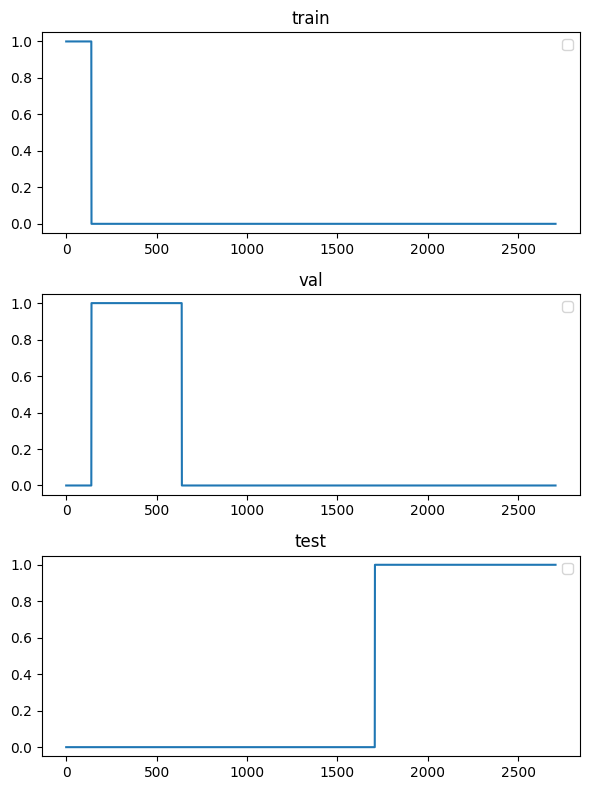

% data used: tensor(0.6056)


In [22]:
fig, axs = plt.subplots(3, 1, figsize=(6, 8))

# Plot the first graph
axs[0].plot(data.train_mask.long())
axs[0].set_title('train')
axs[0].legend()

# Plot the second graph
axs[1].plot(data.val_mask.long())
axs[1].set_title('val')
axs[1].legend()

# Plot the third graph
axs[2].plot(data.test_mask.long())
axs[2].set_title('test')
axs[2].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()
#plt.plot(data.test_mask.long()+data.train_mask.long()+data.val_mask.long())
print('% data used:', torch.sum(data.test_mask.long()+data.train_mask.long()+data.val_mask.long())/len(data.train_mask.long()))

In [23]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import torch

def evaluate_node_classification(aa_node_ids, aa_embeddings, data):
    """
    Evaluates multi-class node classification using Logistic Regression.

    Args:
        aa_node_ids: List of node IDs.
        aa_embeddings: Corresponding node embeddings.
        data: PyTorch Geometric data object containing labels and masks.

    Returns:
        Micro-F1 and Macro-F1 scores.
    """

    # Map node IDs to indices in embeddings
    node_to_idx = {node_id.item(): idx for idx, node_id in enumerate(aa_node_ids)}

    # Reorder embeddings to match the label ordering
    ordered_embeddings = np.zeros((len(data.y), aa_embeddings.shape[1]))
    for i in range(len(data.y)):
        ordered_embeddings[i] = aa_embeddings[node_to_idx[i]]

    # Convert masks to NumPy arrays
    train_mask = data.train_mask.numpy()
    test_mask = data.test_mask.numpy()

    # Prepare train and test data
    X_train, X_test = ordered_embeddings[train_mask], ordered_embeddings[test_mask]
    y_train, y_test = data.y[train_mask].numpy(), data.y[test_mask].numpy()

    # Train Logistic Regression classifier
    clf = LogisticRegression(max_iter=1000, solver='lbfgs')
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Compute Micro-F1 and Macro-F1 scores
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    macro_f1 = f1_score(y_test, y_pred, average='macro')

    return {
        'micro_f1': micro_f1,
        'macro_f1': macro_f1
    }


In [32]:
aa_node_ids_a, aa_embeddings_a = get_embeddings(prev_edges, "prev_edgelist.txt", k=128, partition=1)

In [33]:
print(aa_node_ids_a.shape)
print(aa_embeddings_a.shape)
print(aa_node_ids_a[:10])
print(aa_embeddings_a[:10])

torch.Size([19717])
torch.Size([19717, 128])
tensor([   0,  633, 1866,  926, 1862, 1166, 2582,  216,  226,  235],
       dtype=torch.int32)
tensor([[-0.2587, -0.4433,  0.9600,  ..., -0.3558,  0.4964, -0.6269],
        [-0.2587, -0.4433,  0.9600,  ..., -0.3558,  0.4964, -0.6269],
        [-0.2587, -0.4433,  0.9600,  ..., -0.3558,  0.4964, -0.6269],
        ...,
        [-0.2588, -0.4434,  0.9600,  ..., -0.3560,  0.4964, -0.6268],
        [-0.2588, -0.4434,  0.9600,  ..., -0.3560,  0.4964, -0.6268],
        [-0.2588, -0.4434,  0.9600,  ..., -0.3560,  0.4964, -0.6268]],
       dtype=torch.float64)


In [34]:
aa_node_ids_b, aa_embeddings_b = get_embeddings(new_edges, "new_edgelist.txt", k=128, partition=1)

In [35]:
print(aa_node_ids_b.shape)
print(aa_embeddings_b.shape)
print(aa_node_ids_b[:10])
print(aa_embeddings_b[:10])

torch.Size([19717])
torch.Size([19717, 128])
tensor([   0, 2582,  926, 1862, 1132, 1166, 2755, 4277, 6875, 7936],
       dtype=torch.int32)
tensor([[-0.6648, -0.3022,  0.9841,  ..., -0.4060, -0.6653, -0.1331],
        [-0.6648, -0.3022,  0.9841,  ..., -0.4060, -0.6653, -0.1331],
        [-0.6648, -0.3022,  0.9841,  ..., -0.4060, -0.6653, -0.1331],
        ...,
        [-0.6648, -0.3022,  0.9841,  ..., -0.4061, -0.6654, -0.1329],
        [-0.6648, -0.3022,  0.9841,  ..., -0.4061, -0.6654, -0.1329],
        [-0.6648, -0.3022,  0.9841,  ..., -0.4061, -0.6654, -0.1329]],
       dtype=torch.float64)


In [244]:
final_matrix = adj_matrix
i, j = torch.where(final_matrix == 1)
edges = torch.stack((i, j), dim=0)

print('Only Initial Edges:')
a = []
b = []
for i in tqdm(range(256)):
    aa_node_ids, aa_embeddings = get_embeddings(prev_edges, "prev_edgelist.txt", k=128, partition=1)
    result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
    a.append(result['micro_f1'])
    b.append(result['macro_f1'])

print(f"Micro-F1: {np.mean(a):.4f} ± {np.std(a):.4f}")
print(f"Macro-F1: {np.mean(b):.4f} ± {np.std(b):.4f}")

print('Combined Edges:')
a = []
b = []
for i in tqdm(range(256)):
    aa_node_ids, aa_embeddings = get_embeddings(new_edges, "new_edgelist.txt", k=128, partition=1)
    result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
    a.append(result['micro_f1'])
    b.append(result['macro_f1'])

print(f"Micro-F1: {np.mean(a):.4f} ± {np.std(a):.4f}")
print(f"Macro-F1: {np.mean(b):.4f} ± {np.std(b):.4f}")

Only Initial Edges:


  0%|          | 0/256 [00:00<?, ?it/s]/home/bolt17/miniconda3/envs/StableVITON/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/bolt17/miniconda3/envs/StableVITON/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
  1%|          | 2/256 [00:00<00:18, 13.86it/s]/home/bolt17/miniconda3/envs/StableVITON/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to 

Micro-F1: 0.7210 ± 0.0000
Macro-F1: 0.7002 ± 0.0000
Combined Edges:


  0%|          | 0/256 [00:00<?, ?it/s]/home/bolt17/miniconda3/envs/StableVITON/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/bolt17/miniconda3/envs/StableVITON/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
  1%|          | 2/256 [00:00<00:20, 12.26it/s]/home/bolt17/miniconda3/envs/StableVITON/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to 

Micro-F1: 0.7210 ± 0.0000
Macro-F1: 0.7002 ± 0.0000


In [239]:
aa_embeddings.shape

torch.Size([2708, 128])

# GCN Stuff

In [ ]:

# Define a simple Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the model, optimizer, and loss function
model = GCN(in_channels=data.num_features, hidden_channels=64, out_channels=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.NLLLoss()

# Split the dataset into train, validation, and test sets
train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = loss_fn(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluation function
def evaluate(mask):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = (pred[mask] == data.y[mask]).sum()
        acc = correct / mask.sum()
    return acc.item()

# Train the model
for epoch in range(200):
    loss = train()
    if epoch % 20 == 0:
        val_acc = evaluate(val_mask)
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Val Accuracy: {val_acc:.4f}')

# Test the model
test_acc = evaluate(test_mask)
print(f'Test Accuracy: {test_acc:.4f}')


In [109]:

os.system('ls')

LouvainNE
data
edgelist.txt
hierarchy.txt
node_classification copy.ipynb
node_classification.ipynb
vectors.txt


0

In [89]:
!git clone https://github.com/maxdan94/LouvainNE.git

Cloning into 'LouvainNE'...
remote: Enumerating objects: 217, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 217 (delta 2), reused 9 (delta 2), pack-reused 208 (from 1)
Receiving objects: 100% (217/217), 65.80 KiB | 863.00 KiB/s, done.
Resolving deltas: 100% (125/125), done.
